In [1]:
CPU_usage = False #use for loading and preprocessing images
GPU_usage = not CPU_usage # use after inages have already been loaded in a previous cycle

In [27]:
# --- Install Required Packages ---
!pip install scikit-optimize
!pip install tqdm_joblib
!pip install umap-learn
!pip install PyWavelets

# --- Standard Library Imports ---
import os
import random
import re
import warnings
import multiprocessing
from pathlib import Path

# --- Google Colab / IPython Imports ---
from google.colab import drive
from IPython.display import Image

# --- Third-Party Library Imports ---
import zipfile
import cv2
import cupy as cp
import cuml
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import torch
import logging
import umap
from joblib import Parallel, delayed
from scipy.stats import kurtosis, skew
from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import (
    hog, local_binary_pattern, graycomatrix, graycoprops
)
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from transformers import (
    ViTModel, ViTImageProcessor, ViTFeatureExtractor
)

# --- CuML Imports ---
from cuml.pipeline import Pipeline as cuPipeline
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLogReg
from cuml.model_selection import StratifiedKFold as cuStratifiedKFold
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors
from cuml.svm import SVC as cuSVC

# --- Imbalanced-Learn Imports ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Scikit-Optimize Imports ---
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

# --- Scikit-Learn Imports ---
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, f1_score
)
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# --- XGBoost Imports ---
from xgboost import XGBClassifier

# --- Configuration ---
random.seed(42)
warnings.filterwarnings("ignore")

# Get the logger used by the cuml library and set its level
logging.getLogger('cuml').setLevel(logging.ERROR)


# EDA (TODO)

## Visualization & EDA Helper Functions

In [3]:
def whoAmI(img):
    """
    Prints dtype, min, max, mean, height, and width of an image.
    """
    print(f"dtype     : {img.dtype}")
    print(f"min       : {np.min(img):.4f}")
    print(f"max       : {np.max(img):.4f}")
    print(f"mean      : {np.mean(img):.4f}")
    print(f"shape     : {img.shape}")
    if img.ndim == 2:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
    elif img.ndim == 3:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
        print(f"channels  : {img.shape[2]}")

#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras history object.

    Parameters:
    - history: Keras history object from model.fit()
    """

    epochs = range(1, len(history.history['loss']) + 1)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()



# Preprocessing Helper Functions

In [3]:
# ---------------------- Hair Removal ----------------------
def remove_hairs(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    result = cv2.inpaint(img, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return result


# ---------------------- Scale Marker Masking ----------------------
def mask_scale_markers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 500 and (w/h > 5 or h/w > 5):
            img[y:y+h, x:x+w] = 0
    return img


# ---------------------- Combined Preprocessing ----------------------
def preprocess_image(img):
    img_no_hair = remove_hairs(img)
    img_clean = mask_scale_markers(img_no_hair)
    return img_clean

# ---------------------- Worker Parallelization Function  ----------------------
def process_single_image_entry(image_path, label, image_id, resize_shape):
    """
    Worker function to load, preprocess, and resize a single image.
    Returns a tuple of (image, label, image_id).
    """
    if os.path.exists(image_path):
        # Load and convert image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply your existing preprocessing steps
        img = preprocess_image(img) # This calls remove_hairs and mask_scale_markers

        # Resize
        img = cv2.resize(img, resize_shape)
        return img, label, image_id

    # Return None if the file path is invalid
    return None, None, None

# ---------------------- Master Parallelization Function  ----------------------
def preprocess_all_images_parallel(df, resize_shape=(224, 224)):
    """
    Preprocesses all images from the DataFrame in parallel with a progress bar.
    """
    # Use the tqdm_joblib context manager for a clean progress bar
    with tqdm_joblib(desc="Preprocessing Images", total=len(df)) as progress_bar:
        results = Parallel(n_jobs=-1, verbose=0)(
            delayed(process_single_image_entry)(
                row['path'], row['dx'], row['image_id'], resize_shape
            )
            for _, row in df.iterrows()
        )

    # Filter out any failed results (where the image path was invalid)
    valid_results = [res for res in results if res[0] is not None]

    # Unzip the list of tuples into separate lists
    images, labels, image_ids = zip(*valid_results)

    return np.array(images), list(labels), list(image_ids)

# CPU and GPU separated Image Loading and preprocessing


*   Unzips, loads images, applies preprocessing to image
*   Produces processed_images (np.array), labels (list),
image_ids (list)







In [5]:
CPU_usage = CPU_usage #use for loading and preprocessing images
GPU_usage = not CPU_usage

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

# Base paths
base_dir = Path('/content/drive/MyDrive/w81_fp')
zip_path = base_dir / 'HAM10000_images.zip'
img_dir = base_dir / 'HAM10000_images'

if CPU_usage:
  # Unzip only if folder doesn't exist
  if not img_dir.exists():
      print("Unzipping image archive...")
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(base_dir)


Mounted at /content/drive


In [7]:
# Load metadata and prepare image paths
if CPU_usage:
  df = pd.read_csv(base_dir / 'HAM10000_metadata.csv')
  image_ids = list(df['image_id'])
  labels = list(df['dx'])

  # Full image paths
  image_paths = [img_dir / f"{img_id}.jpg" for img_id in image_ids]


In [8]:
# Parallel preprocessing
if CPU_usage:
  results = Parallel(n_jobs=-1, verbose=1)(
      delayed(process_single_image_entry)(str(path), lbl, img_id,resize_shape=(224, 224))
      for path, lbl, img_id in zip(image_paths, labels, image_ids)
  )

  # Filter out failures
  filtered = [(img, lbl, img_id) for img, lbl, img_id in results if img is not None]

  # Unpack
  processed_images, labels, image_ids = zip(*filtered)
  processed_images = np.array(processed_images)
  labels = list(labels)
  image_ids = list(image_ids)

  print("Processed image array shape:", processed_images.shape)


In [9]:
# Save processed images to persistent storage, using CPU cycle.
# processed_images: np.array
# labels: list of strings
# image_ids: list of strings

if CPU_usage:
  np.savez_compressed(base_dir / "processed_data.npz",
                      images=processed_images,
                      labels=np.array(labels),
                      image_ids=np.array(image_ids))

  print("Data saved to:", base_dir / "processed_data.npz")


In [10]:
# When using GPU,
if GPU_usage:
  data = np.load(base_dir / "processed_data.npz", allow_pickle=True)

  processed_images = data['images']
  labels = data['labels'].tolist()
  image_ids = data['image_ids'].tolist()

  print(f"GPU, Loaded { processed_images.shape = }, { len(labels) = } , { len(image_ids) =} ")


GPU, Loaded  processed_images.shape = (10015, 224, 224, 3),  len(labels) = 10015 ,  len(image_ids) =10015 


In [11]:
print("-"*100)
print(f"CPU or GPU, Loaded { CPU_usage = }, { GPU_usage = } \n { processed_images.shape = }, { len(labels) = } , { len(image_ids) =} ")

----------------------------------------------------------------------------------------------------
CPU or GPU, Loaded  CPU_usage = False,  GPU_usage = True 
  processed_images.shape = (10015, 224, 224, 3),  len(labels) = 10015 ,  len(image_ids) =10015 


# Feature Extraction Helper Functions

## Simple Feature Extraction

In [33]:
# HSV Features
def compute_hsv_histogram(img, h_bins=16, s_bins=8, v_bins=8):
    """
    Compute a normalized HSV color histogram from an RGB image.

    Args:
        img (np.ndarray): RGB image.
        h_bins, s_bins, v_bins: Number of bins for H, S, and V channels.

    Returns:
        np.ndarray: Flattened and normalized HSV histogram.
    """
    # Convert from RGB to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Compute 3D histogram
    hist = cv2.calcHist(
        [hsv], [0, 1, 2], None,
        [h_bins, s_bins, v_bins],
        [0, 180, 0, 256, 0, 256]
    )

    # Normalize and flatten
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hsv_features_from_array(image_array, bins=(16, 8, 8)):
    h_bins, s_bins, v_bins = bins
    with tqdm_joblib(desc="Extracting HSV Features", total=len(image_array)) as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_hsv_histogram)(img, h_bins, s_bins, v_bins) for img in image_array
        )
    return np.array(features)

In [34]:
# HoG Features
def compute_hog(img):
    gray_img = rgb2gray(img)
    features = hog(
        gray_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features

def extract_hog_features_from_array(image_array):
    with tqdm_joblib(desc="Extracting HOG Features", total=len(image_array)) as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_hog)(img) for img in image_array
        )
    return np.array(features)

In [35]:
# LBP Features
def compute_lbp_features(img, radius=1, n_points=8, method='uniform'):
    """
    Compute a normalized LBP histogram from a grayscale version of the RGB image.

    Args:
        img (np.ndarray): RGB image.
        radius (int): Radius of circle.
        n_points (int): Number of sampling points.
        method (str): LBP method ('uniform', 'default', etc.).

    Returns:
        np.ndarray: Normalized LBP histogram (1D feature vector).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method=method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist




def extract_lbp_features_from_array(image_array, radius=1, n_points=8, method='uniform'):
    with tqdm_joblib(desc="Extracting LBP Features", total=len(image_array)) as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_lbp_features)(img, radius, n_points, method) for img in image_array
        )
    return np.array(features)

In [36]:
# Sobel Edge Mean Features
def compute_sobel_features(img):
    """
    Computes descriptive statistics from the Sobel gradient magnitude.

    This more descriptive version includes measures of central tendency,
    dispersion, and shape of the gradient magnitude distribution.

    Args:
        img (np.ndarray): The input RGB image.

    Returns:
        np.ndarray: A 1D feature vector containing:
                    - mean
                    - standard deviation
                    - skewness
                    - kurtosis
                    - entropy
                    - 25th percentile
                    - median (50th percentile)
                    - 75th percentile
    """
    # 1. Convert to grayscale for edge detection
    gray = rgb2gray(img)

    # 2. Apply the Sobel filter to get the gradient magnitude
    sobel_magnitude = sobel(gray)

    # 3. Flatten the 2D magnitude image to a 1D array for most stats
    flat_magnitude = sobel_magnitude.flatten()

    # 4. Compute descriptive statistics
    features = [
        np.mean(flat_magnitude),
        np.std(flat_magnitude),
        skew(flat_magnitude),
        kurtosis(flat_magnitude),
        shannon_entropy(sobel_magnitude), # Entropy works on the 2D image
        np.percentile(flat_magnitude, 25),
        np.median(flat_magnitude),
        np.percentile(flat_magnitude, 75)
    ]
    return np.array(features)


# --- Parallel Extraction Function (No changes needed) ---
def extract_sobel_features_from_array(image_array):
    """Extracts Sobel features from an array of images in parallel."""
    # This function does not need to be changed.
    features = Parallel(n_jobs=-1, verbose=0)(
        delayed(compute_sobel_features)(img) for img in image_array
    )
    return np.array(features)

In [37]:
# Wavelet features (using Haar)
def compute_wavelet_features(img):
    """
    Computes wavelet features using the Haar transform.

    Args:
        img (np.ndarray): RGB image.

    Returns:
        np.ndarray: A 1D feature vector containing mean of approximation
                    coefficients and energy of detail coefficients.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Resize to an even dimension if necessary for wavelet transform
    height, width = gray.shape
    if height % 2 != 0 or width % 2 != 0:
        gray = cv2.resize(gray, (width - width % 2, height - height % 2))

    cA, (cH, cV, cD) = pywt.dwt2(gray, 'haar')
    wavelet_features = [
        np.mean(cA),
        np.sum(cH**2),
        np.sum(cV**2),
        np.sum(cD**2)
    ]
    return np.array(wavelet_features)


def extract_wavelet_features_from_array(image_array):
    """Extracts wavelet features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Wavelet Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_wavelet_features)(img) for img in image_array
        )
    return np.array(features)

In [38]:
# Color Features
def compute_color_features(img, hist_bins=(8, 8, 8)):
    """
    Computes color statistics (mean, std) and a normalized color histogram.

    Args:
        img (np.ndarray): RGB image.
        hist_bins (tuple): Number of bins for R, G, and B channels.

    Returns:
        np.ndarray: A concatenated 1D feature vector containing
                    mean RGB, std dev RGB, and the flattened normalized histogram.
    """
    # 1. Color Statistics
    mean_rgb = img.mean(axis=(0, 1))
    std_rgb = img.std(axis=(0, 1))

    # 2. Color Histogram
    hist = cv2.calcHist(
        [img], [0, 1, 2], None, hist_bins,
        [0, 256, 0, 256, 0, 256]
    )

    # Normalize and flatten
    hist = cv2.normalize(hist, hist).flatten()

    return np.concatenate([mean_rgb, std_rgb, hist])

def extract_color_features_from_array(image_array, hist_bins=(8, 8, 8)):
    """Extracts color features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Color Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_color_features)(img, hist_bins) for img in image_array
        )
    return np.array(features)


In [39]:
# Statistical features
def compute_intensity_stats(img):
    """
    Computes statistical moments of the pixel intensities.

    Args:
        img (np.ndarray): RGB image.

    Returns:
        np.ndarray: A 1D feature vector containing mean, standard deviation,
                    skewness, and kurtosis of the grayscale image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pixels = gray.flatten()

    features = [
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels)
    ]
    return np.array(features)


def extract_intensity_stats_from_array(image_array):
    """Extracts intensity statistics from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Intensity Stats") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_intensity_stats)(img) for img in image_array
        )
    return np.array(features)


In [40]:
# GLCM Features
def compute_glcm_features(img, distances=[5], angles=[0]):
    """
    Computes texture features using a Gray-Level Co-occurrence Matrix (GLCM).

    Args:
        img (np.ndarray): RGB image.
        distances (list): List of pixel pair distance offsets.
        angles (list): List of pixel pair angles in radians.

    Returns:
        np.ndarray: A 1D feature vector containing contrast, dissimilarity,
                    homogeneity, ASM, energy, and correlation.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    glcm = graycomatrix(
        gray, distances=distances, angles=angles,
        levels=256, symmetric=True, normed=True
    )

    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    features = [graycoprops(glcm, prop)[0, 0] for prop in props]

    return np.array(features)

def extract_glcm_features_from_array(image_array, distances=[5], angles=[0]):
    """Extracts GLCM features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting GLCM Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_glcm_features)(img, distances, angles) for img in image_array
        )
    return np.array(features)


In [41]:
# Gabor Features
def compute_gabor_features(img, resize_dim=(224, 224), orientations=6, scales=(1, 3, 5, 7)):
    """
    Computes features using a bank of Gabor filters.

    Args:
        img (np.ndarray): RGB image.
        resize_dim (tuple): Dimensions to resize the image to. Set to None to skip.
        orientations (int): Number of filter orientations.
        scales (tuple): A tuple of sigma values for the Gabor kernels.

    Returns:
        np.ndarray: A 1D vector containing the mean and std dev of each filtered response.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if resize_dim:
        gray = cv2.resize(gray, resize_dim)

    features = []
    thetas = np.linspace(0, np.pi, orientations, endpoint=False)

    for theta in thetas:
        for sigma in scales:
            kernel = cv2.getGaborKernel(
                ksize=(21, 21), sigma=sigma, theta=theta,
                lambd=10.0, gamma=0.5, psi=0, ktype=cv2.CV_32F
            )
            filtered = cv2.filter2D(gray, ddepth=-1, kernel=kernel)
            features.extend([filtered.mean(), filtered.std()])

    return np.array(features)


def extract_gabor_features_from_array(image_array, resize_dim=(224, 224), orientations=6, scales=(1, 3, 5, 7)):
    """Extracts Gabor features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Gabor Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_gabor_features)(img, resize_dim, orientations, scales) for img in image_array
        )
    return np.array(features)

In [42]:
# Shape Features
def compute_shape_features(img):
    """
    Computes shape features from the largest contour in the image.

    Args:
        img (np.ndarray): RGB image.

    Returns:
        np.ndarray: A 1D vector of [area, perimeter, compactness].
                    Returns zeros if no contours are found.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return np.zeros(3)

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    if area == 0:
        return np.zeros(3)

    compactness = (perimeter ** 2) / (4 * np.pi * area)

    return np.array([area, perimeter, compactness])

def extract_shape_features_from_array(image_array):
    """Extracts shape features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Shape Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_shape_features)(img) for img in image_array
        )
    return np.array(features)

In [43]:
# Corner Features
def compute_corner_features(img, max_corners=100, quality_level=0.01, min_distance=10):
    """
    Computes the number of corners detected by the Shi-Tomasi method.

    Args:
        img (np.ndarray): RGB image.
        max_corners (int): Maximum number of corners to return.
        quality_level (float): Parameter for corner detection (0-1).
        min_distance (int): Minimum Euclidean distance between corners.

    Returns:
        np.ndarray: A 1D array with a single feature: the corner count.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    corners = cv2.goodFeaturesToTrack(
        gray, maxCorners=max_corners,
        qualityLevel=quality_level,
        minDistance=min_distance
    )

    num_corners = 0 if corners is None else len(corners)
    return np.array([num_corners])

def extract_corner_features_from_array(image_array, max_corners=100, quality_level=0.01, min_distance=10):
    """Extracts corner features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Corner Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_corner_features)(img, max_corners, quality_level, min_distance) for img in image_array
        )
    return np.array(features)

In [44]:
# SIFT Features
def compute_sift_features(img, max_features=50):
    """
    Computes SIFT features and returns a fixed-size vector by padding/truncating.

    Args:
        img (np.ndarray): RGB image.
        max_features (int): The target number of descriptors.

    Returns:
        np.ndarray: A flattened 1D feature vector of size (max_features * 128).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        return np.zeros(max_features * 128)

    num_descriptors = descriptors.shape[0]
    if num_descriptors < max_features:
        pad_width = max_features - num_descriptors
        # Pad with zeros to reach max_features
        feature_vec = np.pad(descriptors, ((0, pad_width), (0, 0)), 'constant')
    else:
        # Truncate to keep only the first max_features
        feature_vec = descriptors[:max_features, :]

    return feature_vec.flatten()

def extract_sift_features_from_array(image_array, max_features=50):
    """Extracts fixed-size SIFT features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting SIFT Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_sift_features)(img, max_features) for img in image_array
        )
    return np.array(features)

## Complex Feature Extraction

In [47]:
def extract_vit_features_from_array(image_array, model, feature_processor, batch_size=32):
    """
    Extracts ViT [CLS] token embeddings from an array of RGB images using batch processing.

    Args:
        image_array (np.ndarray or list): A list or array of RGB images (H, W, C).
        model (torch.nn.Module): The pre-trained Vision Transformer model.
        feature_processor (ViTImageProcessor): The processor to prepare images for the model.
        batch_size (int): The number of images to process in a single batch.

    Returns:
        np.ndarray: A 2D array where each row is the [CLS] embedding for an image.
    """
    # Determine the device and move the model to it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_features = []
    num_images = len(image_array)

    # Process images in batches
    with tqdm_joblib(total=num_images, desc="Extracting ViT Features (Batching)") as pbar:
        for i in range(0, num_images, batch_size):
            # Create a batch of images
            batch_images = image_array[i:i + batch_size]

            # The feature processor expects a list of images
            inputs = feature_processor(images=list(batch_images), return_tensors="pt").to(device)

            # Perform inference without calculating gradients
            with torch.no_grad():
                outputs = model(**inputs)

            # Extract the [CLS] token's embeddings
            # The [CLS] token is always the first one
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_features.append(cls_embeddings)

            pbar.update(len(batch_images))

    # Concatenate all batch results into a single NumPy array
    return np.vstack(all_features)


# Model Selection & Configuration

In [28]:
MODELS = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(5, 50),
            'model__min_samples_split': Integer(2, 12),
            'model__min_samples_leaf': Integer(1, 10),
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(3, 15),
            'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
            'model__subsample': Real(0.6, 1.0),
            'model__colsample_bytree': Real(0.6, 1.0),
        }
    },
    'SVC': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
            'model__gamma': Real(1e-4, 1e-1, prior='log-uniform'),
            'model__kernel': Categorical(['rbf', 'poly']),
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': Integer(3, 30),
            'model__weights': Categorical(['uniform', 'distance']),
            'model__p': Integer(1, 2) # 1 for Manhattan, 2 for Euclidean
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
        'params': {
            'model__penalty': Categorical(['l1', 'l2']),
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
        }
    }
}

In [29]:
MODELS_CUML = {
    'RandomForest_GPU': {
        'model': cuRF(random_state=42),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(5, 50),
            'model__n_bins': Integer(8, 128),
        }
    },
    'RandomForest_GPU_Balanced': {
        'model': cuRF(random_state=42),
        'params': {
            'n_estimators': Integer(50, 500),
            'max_depth': Integer(5, 50),
            'n_bins': Integer(8, 128),
        }
    },
    'XGBoost_GPU': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False,
                               eval_metric='mlogloss', tree_method='gpu_hist'),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(3, 15),
            'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        }
    },
    'XGBoost_GPU_Balanced': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False,
                               eval_metric='mlogloss', tree_method='gpu_hist'),
        'params': {
            'n_estimators': Integer(50, 500),
            'max_depth': Integer(3, 15),
            'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        }
    },
    'SVC_GPU': {
        'model': cuSVC(random_state=42, probability=True),
        'params': {
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
            'model__gamma': Real(1e-4, 1e-1, prior='log-uniform'),
        }
    },
    'SVC_GPU_Balanced': {
        'model': cuSVC(random_state=42, probability=True, class_weight='balanced'),
        'params': {
            'C': Real(1e-3, 1e3, prior='log-uniform'),
            'gamma': Real(1e-4, 1e-1, prior='log-uniform'),
        }
    },
    'KNeighbors_GPU': {
        'model': cuKNeighbors(),
        'params': {
            'model__n_neighbors': Integer(3, 30),
            'model__p': Integer(1, 2)
        }
    },
    'KNeighbors_GPU_Balanced': {
        'model': cuKNeighbors(),
        'params': {
            'n_neighbors': Integer(3, 30),
            'p': Integer(1, 2)
        }
    },
    'LogisticRegression_GPU': {
        'model': cuLogReg(max_iter=10000),
        'params': {
            'model__penalty': Categorical(['l1', 'l2']),
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
        }
    },
    'LogisticRegression_GPU_Balanced': {
        'model': cuLogReg(max_iter=10000),
        'params': {
            'penalty': Categorical(['l1', 'l2']),
            'C': Real(1e-3, 1e3, prior='log-uniform'),
        }
    }
}

[2025-07-26 21:22:40.465] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-26 21:22:40.467] [CUML] [warning] Random state is currently ignored by probabilistic SVC


# Hyperparameter Search & Model Evaluation

In [6]:
def run_auc_roc_gpu_evaluation_with_per_fold_sampling(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated pipeline for a single specified model.

    This function preserves the per-fold oversampling strategy and is designed
    for iterative execution in environments like Jupyter notebooks.

    Args:
        model_name (str): The name of the model to evaluate. Must be a key
                          in the global MODELS_CUML dictionary.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model,
              keyed by the model's name.
    """
    # Check if the requested model exists in the configuration dictionary
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    # Get the configuration for the specified model
    config = MODELS_CUML[model_name]

    # Step 1: Stratified Train-Test Split (remains on CPU)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    # Split the full training set again into a smaller training set and a validation set for threshold tuning
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=random_state # 0.25 * 0.8 = 0.2
    )

    print(f"--- Starting Evaluation for: {model_name} ---")

    # Step 2: Create a pipeline that first oversamples (CPU), then fits the model (GPU)
    pipeline = ImbPipeline([
        ('sampler', RandomOverSampler(sampling_strategy='not majority', random_state=random_state)),
        ('model', config['model'])
    ])

    # Step 3: Set up cross-validation and hyperparameter search
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=config['params'],
        n_iter=25,
        cv=cv,
        scoring='roc_auc_ovr',
        n_jobs=1,  # Parallelism is on the GPU
        random_state=random_state,
        verbose=1
    )

    # Step 4: Run the Bayesian search
    print("Running Bayesian search (with per-fold CPU-GPU data transfer)...")
    bayes_search.fit(X_train, y_train)

    # Step 5: Find the best thresholds for prediction
    best_model = bayes_search.best_estimator_
    y_val_pred_proba = best_model.predict_proba(X_val)

    print("Finding optimal thresholds on validation set...")
    thresholds = []
    # Iterate over each class
    for i in range(y_val_pred_proba.shape[1]):
        best_f1 = 0
        best_thresh = 0.5 # Default threshold
        # Iterate over a range of potential thresholds
        for thresh in np.arange(0.01, 1.0, 0.01):
            # Apply threshold to get binary predictions for the current class
            y_pred_binary = (y_val_pred_proba[:, i] >= thresh).astype(int)
            # Binarize the true labels for the current class
            y_true_binary = (y_val == i).astype(int)

            f1 = f1_score(y_true_binary, y_pred_binary)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)

    print(f"Optimal thresholds found: {np.round(thresholds, 2)}")

    # Step 5: Evaluate using custom thresholds on the hold-out test set
    print("Evaluating best model on the hold-out test set with custom thresholds...")

    # Get probabilities on the test set
    y_test_pred_proba = best_model.predict_proba(X_test)

    # Apply custom thresholds to get final predictions
    final_predictions = []
    for probs in y_test_pred_proba:
        # Find which classes meet their threshold
        passed_threshold_indices = [i for i, prob in enumerate(probs) if prob >= thresholds[i]]

        if len(passed_threshold_indices) == 0:
            # If no class passes its threshold, fall back to the highest probability
            final_predictions.append(np.argmax(probs))
        else:
            # If one or more classes pass, predict the one with the highest probability among them
            best_class = -1
            max_prob = -1
            for idx in passed_threshold_indices:
                if probs[idx] > max_prob:
                    max_prob = probs[idx]
                    best_class = idx
            final_predictions.append(best_class)

    # Try this next to improve performance
    # thresholds_arr = np.array(thresholds)

    # # Avoid division by zero if a threshold is 0
    # thresholds_arr[thresholds_arr == 0] = 1e-9

    # # Divide probabilities by their respective thresholds and find the class with the highest resulting score
    # y_test_pred = np.argmax(y_test_pred_proba / thresholds_arr, axis=1)
    y_test_pred = np.array(final_predictions)

    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro')

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    # Store results for the single model
    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_roc_auc': bayes_search.best_score_,
        'test_set_roc_auc': test_auc,
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation AUC-ROC score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    # Return results in a dictionary keyed by model name for consistent structure
    return {model_name: final_results}

In [24]:
def run_auc_roc_gpu_evaluation_with_class_weights(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated evaluation for a single model using balanced class weights.

    This function expects the model to handle class imbalance internally via
    the `class_weight='balanced'` parameter, instead of using oversampling.

    Args:
        model_name (str): The name of the model to evaluate from MODELS_CUML. The model
                          should be instantiated with `class_weight='balanced'`.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model.
    """
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    config = MODELS_CUML[model_name]

    # Step 1: Data splitting (remains the same)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=random_state
    )

    print(f"--- Starting Evaluation for: {model_name} (using class weights) ---")

    # Step 2: Set up hyperparameter search directly on the model
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    bayes_search = BayesSearchCV(
        estimator=config['model'],
        search_spaces=config['params'],
        n_iter=2, # have to set this in order for SVC to complete
        cv=cv,
        scoring='roc_auc_ovr',
        n_jobs=1,
        random_state=random_state,
        verbose=1
    )

    # Step 3: Run the Bayesian search
    print("Running Bayesian search...")
    bayes_search.fit(X_train, y_train)

    # Step 4: Find optimal thresholds (remains the same)
    best_model = bayes_search.best_estimator_
    y_val_pred_proba = best_model.predict_proba(X_val)

    print("Finding optimal thresholds on validation set...")
    thresholds = []
    for i in range(y_val_pred_proba.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for thresh in np.arange(0.01, 1.0, 0.01):
            y_pred_binary = (y_val_pred_proba[:, i] >= thresh).astype(int)
            y_true_binary = (y_val == i).astype(int)
            f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)
    print(f"Optimal thresholds found: {np.round(thresholds, 2)}")

    # Step 5: Evaluate on test set with custom thresholds (remains the same)
    print("Evaluating best model on the hold-out test set with custom thresholds...")
    y_test_pred_proba = best_model.predict_proba(X_test)

    final_predictions = []
    for probs in y_test_pred_proba:
        passed_threshold_indices = [i for i, prob in enumerate(probs) if prob >= thresholds[i]]
        if not passed_threshold_indices:
            final_predictions.append(np.argmax(probs))
        else:
            best_class = max(passed_threshold_indices, key=lambda idx: probs[idx])
            final_predictions.append(best_class)

    y_test_pred = np.array(final_predictions)

    # Final reporting
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro')

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_roc_auc': bayes_search.best_score_,
        'test_set_roc_auc': test_auc,
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation AUC-ROC score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    return {model_name: final_results}

In [8]:
def run_f1_gpu_evaluation_with_per_fold_sampling(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated pipeline for a single specified model,
    optimized directly for the 'f1_macro' score.

    This version changes the Bayesian search scoring to f1_macro and
    removes the subsequent manual threshold tuning step.

    Args:
        model_name (str): The name of the model to evaluate. Must be a key
                          in the global MODELS_CUML dictionary.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model,
              keyed by the model's name.
    """
    # Check if the requested model exists in the configuration dictionary
    if model_name not in MODELS_CUML:
        raise ValueError(
            f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}"
        )

    # Get the configuration for the specified model
    config = MODELS_CUML[model_name]

    # Step 1: Stratified Train-Test Split (remains on CPU)
    # We no longer need a separate validation set for thresholding
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    print(f"--- Starting F1-Optimized Evaluation for: {model_name} ---")

    # Step 2: Create a pipeline that first oversamples (CPU), then fits the model (GPU)
    pipeline = ImbPipeline(
        [
            ("sampler", RandomOverSampler(sampling_strategy="not majority", random_state=random_state)),
            ("model", config["model"]),
        ]
    )

    # Step 3: Set up cross-validation and hyperparameter search
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=config["params"],
        n_iter=25,
        cv=cv,
        scoring="f1_macro",  # Optimize directly for the desired metric
        n_jobs=1,  # Parallelism is on the GPU
        random_state=random_state,
        verbose=1,
    )

    # Step 4: Run the Bayesian search
    print("Running Bayesian search (optimizing for F1-score)...")
    bayes_search.fit(X_train, y_train)

    # Step 5: Evaluate the best model on the hold-out test set
    # The manual thresholding step is removed as it's no longer necessary.
    print("Evaluating best model on the hold-out test set...")
    best_model = bayes_search.best_estimator_

    # Get predictions using the model's default (0.5) threshold,
    # which the bayes_search has implicitly optimized for.
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)

    # Generate the classification report and other metrics
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

    test_metrics = {
        "roc_auc_macro": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_test_pred),
        "precision_macro": report_dict["macro avg"]["precision"],
        "recall_macro": report_dict["macro avg"]["recall"],
        "f1_macro": report_dict["macro avg"]["f1-score"],
        "precision_weighted": report_dict["weighted avg"]["precision"],
        "recall_weighted": report_dict["weighted avg"]["recall"],
        "f1_weighted": report_dict["weighted avg"]["f1-score"],
    }

    # Store results for the single model
    final_results = {
        "best_model": best_model,
        "test_set_report": pd.DataFrame(report_dict).transpose(),
        "test_set_metrics": test_metrics,
        "best_cv_f1_macro": bayes_search.best_score_, #
        "test_set_roc_auc": test_auc,
        "best_params": bayes_search.best_params_,
    }

    print(f"\nBest cross-validation F1-Macro score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    # Return results in a dictionary keyed by model name for consistent structure
    return {model_name: final_results}

In [9]:
def run_f1_gpu_evaluation_with_class_weights(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated evaluation for a model, optimizing for f1_macro.

    This function expects the model to handle class imbalance internally via
    the `class_weight='balanced'` parameter.

    Args:
        model_name (str): The name of the model to evaluate from MODELS_CUML. The model
                          should be instantiated with `class_weight='balanced'`.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model.
    """
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    config = MODELS_CUML[model_name]

    # Step 1: Simplified data splitting (no validation set needed)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    print(f"--- Starting Evaluation for: {model_name} (optimizing for f1_macro) ---")

    # Step 2: Set up hyperparameter search to optimize for f1_macro
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    bayes_search = BayesSearchCV(
        estimator=config['model'],
        search_spaces=config['params'],
        n_iter=10,
        cv=cv,
        scoring='f1_macro',  # Changed scoring metric
        n_jobs=1,
        random_state=random_state,
        verbose=1
    )

    # Step 3: Run the Bayesian search
    print("Running Bayesian search...")
    bayes_search.fit(X_train, y_train)

    # Step 4: Evaluate the best model on the hold-out test set
    print("Evaluating best model on the hold-out test set...")
    best_model = bayes_search.best_estimator_

    # Use standard .predict() since thresholding is removed
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test) # Still useful for AUC reporting

    # Step 5: Final reporting
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_f1_macro': bayes_search.best_score_, # Updated key
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation F1-macro score: {bayes_search.best_score_:.4f}") # Updated print statement
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set F1-macro score: {test_metrics['f1_macro']:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    return {model_name: final_results}

# Pipeline Execution

## Preprocess & Extract Features

In [ ]:
print(f"CPU or GPU, Loaded { CPU_usage = }, { GPU_usage = } \n { processed_images.shape = }, { len(labels) = } , { len(image_ids) =} ")

In [19]:
# Preprocess images
#processed_images, raw_labels, image_ids = preprocess_all_images_parallel(df)

processed_images, raw_labels, image_ids = processed_images, labels, image_ids


print(f" { processed_images.shape = }, { len(raw_labels) = } , { len(image_ids) =} ")

  processed_images.shape = (10015, 224, 224, 3),  len(raw_labels) = 10015 ,  len(image_ids) =10015 


In [48]:
# Extract Simple Features
X_hog = extract_hog_features_from_array(processed_images)
X_hsv = extract_hsv_features_from_array(processed_images)
X_lbp = extract_lbp_features_from_array(processed_images)
X_color = extract_color_features_from_array(processed_images)
X_intensity = extract_intensity_stats_from_array(processed_images)
X_glcm = extract_glcm_features_from_array(processed_images)
X_gabor = extract_gabor_features_from_array(processed_images)
X_shape = extract_shape_features_from_array(processed_images)
X_corners = extract_corner_features_from_array(processed_images)
X_sift = extract_sift_features_from_array(processed_images)
X_wavelet = extract_wavelet_features_from_array(processed_images)
X_sobel = extract_sobel_features_from_array(processed_images)

Extracting HOG Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting HSV Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting LBP Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting Color Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting Intensity Stats:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting GLCM Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting Gabor Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting Shape Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting Corner Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting SIFT Features:   0%|          | 0/10015 [00:00<?, ?it/s]

Extracting Wavelet Features:   0%|          | 0/10015 [00:00<?, ?it/s]

In [49]:
# SAVE EXTRACTED SIMPLE FEATURES TO PERSISTENT STORAGE
save_path = base_dir / "simple_feature_set_all.npz"

np.savez_compressed(save_path,
    X_hog=X_hog,
    X_hsv=X_hsv,
    X_lbp=X_lbp,
    X_color=X_color,
    X_intensity=X_intensity,
    X_glcm=X_glcm,
    X_gabor=X_gabor,
    X_shape=X_shape,
    X_corners=X_corners,
    X_sift=X_sift,
    X_wavelet=X_wavelet,
    X_sobel=X_sobel,
    labels=np.array(labels),
    image_ids=np.array(image_ids)
)

print(" Features saved to:", save_path)


 Features saved to: /content/drive/MyDrive/w81_fp/simple_feature_set_all.npz


In [35]:
# Extract Complex Features
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
vit_model = ViTModel.from_pretrained(MODEL_NAME) # Load in ViT model
vit_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

X_vit = extract_vit_features_from_array(
    image_array=processed_images,
    model=vit_model,
    feature_processor=vit_processor,
    batch_size=32
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Extracting ViT Features (Batching):   0%|          | 0/10015 [00:00<?, ?it/s]

In [36]:
# Assuming these variables are already defined
# X_vit: np.array of shape (N, D)
# labels: list of labels
# image_ids: list of image IDs

np.savez_compressed(save_path,
                    X_vit=X_vit,
                    labels=np.array(labels),
                    image_ids=np.array(image_ids))

print(f" Saved ViT features to: {save_path}")


 Saved ViT features to: /content/drive/MyDrive/w81_fp/feature_set_all.npz


# Resnet feature extraction and save

In [37]:
!pip install -q torch torchvision tqdm ftfy regex
!pip install -q git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 494.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import numpy as np
from pathlib import Path

# Path to your persistent storage location
base_dir = Path('/content/drive/MyDrive/w81_fp')
data_path = base_dir / 'processed_data.npz'

# Load the compressed .npz file
data = np.load(data_path, allow_pickle=True)

# Extract each component
processed_images = data['images']
labels = data['labels'].tolist()
image_ids = data['image_ids'].tolist()

# Verify
print(" Loaded:")
print("Images shape:", processed_images.shape)
print("Labels count:", len(labels))
print("Image IDs count:", len(image_ids))


 Loaded:
Images shape: (10015, 224, 224, 3)
Labels count: 10015
Image IDs count: 10015


In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

def extract_resnet_features(images_np, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract ResNet-50 features (2048-dim) from a batch of RGB images (np array of shape (N, H, W, 3)).
    """
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # remove final classifier
    model.to(device)
    model.eval()

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225]),
    ])

    features = []

    with torch.no_grad():
        for img in tqdm(images_np, desc="Extracting ResNet Features"):
            input_tensor = preprocess(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)
            feat = model(input_tensor)  # (1, 2048, 1, 1)
            features.append(feat.view(-1).cpu().numpy())  # flatten to (2048,)

    return np.array(features)  # (N, 2048)


In [6]:
X_resnet = extract_resnet_features(processed_images)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting ResNet Features: 100%|██████████| 10015/10015 [01:37<00:00, 102.24it/s]


In [7]:
X_resnet.shape

(10015, 2048)

In [9]:
base_dir = Path("/content/drive/MyDrive/w81_fp")  # Adjust if needed
resnet_save_path = base_dir / "resnet_features_with_ids.npz"

# X_resnet: np.array of shape (N, 2048)
# labels: list of strings
# image_ids: list of strings

np.savez_compressed(resnet_save_path,
                    X_resnet=X_resnet,
                    labels=np.array(labels),
                    image_ids=np.array(image_ids))

print(f" ResNet features saved to: {resnet_save_path}")

 ResNet features saved to: /content/drive/MyDrive/w81_fp/resnet_features_with_ids.npz


# Crash Resilience - optionally load saved feature vectors

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
import numpy as np
from pathlib import Path

# Define base path and file name
base_dir = Path('/content/drive/MyDrive/w81_fp')
feature_path = base_dir / 'simple_feature_set_all.npz'

# # Load the .npz file
data = np.load(feature_path, allow_pickle=True)

print("Available keys:", data.files)

# Extract all feature arrays
X_hog       = data['X_hog']
X_hsv       = data['X_hsv']
X_lbp       = data['X_lbp']
X_color     = data['X_color']
X_intensity = data['X_intensity']
X_glcm      = data['X_glcm']
X_gabor     = data['X_gabor']
X_shape     = data['X_shape']
X_corners   = data['X_corners']
X_sift      = data['X_sift']
X_wavelet   = data['X_wavelet']
X_sobel     = data['X_sobel']

# Also load metadata
labels      = data['labels'].tolist()
image_ids   = data['image_ids'].tolist()

# Summary
print(" Loaded simple feature vectors.")
print("color shape:", X_color.shape)
print("HSV shape:", X_hsv.shape)
print("gabor shape:", X_gabor.shape)
print("LBP shape:", X_lbp.shape)
print("glcm shape:", X_glcm.shape)
print("Labels loaded:", len(labels))


Available keys: ['X_hog', 'X_hsv', 'X_lbp', 'X_color', 'X_intensity', 'X_glcm', 'X_gabor', 'X_shape', 'X_corners', 'X_sift', 'X_wavelet', 'X_sobel', 'labels', 'image_ids']
 Loaded simple feature vectors.
color shape: (10015, 518)
HSV shape: (10015, 1024)
gabor shape: (10015, 48)
LBP shape: (10015, 10)
glcm shape: (10015, 6)
Labels loaded: 10015


# Assessment of color and hsv feature vectors

In [54]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_covariance_matrix(X1, X2, visualize=True, label1='X1', label2='X2'):
    """
    Compute and optionally visualize the covariance matrix of two standardized feature matrices.

    Parameters:
    - X1, X2: NumPy arrays of shape (N_samples, D1) and (N_samples, D2)
    - visualize: If True, plot the covariance matrix as a heatmap
    - label1, label2: Labels for each block of features

    Returns:
    - cov_matrix: (D1 + D2, D1 + D2) covariance matrix
    """
    assert X1.shape[0] == X2.shape[0], "Both matrices must have the same number of samples"

    # Standardize each set independently
    scaler1 = StandardScaler().fit(X1)
    scaler2 = StandardScaler().fit(X2)

    X1_std = scaler1.transform(X1)
    X2_std = scaler2.transform(X2)

    # Concatenate and compute covariance
    X_combined = np.hstack([X1_std, X2_std])
    cov_matrix = np.cov(X_combined, rowvar=False)

    if visualize:
        d1, d2 = X1.shape[1], X2.shape[1]
        labels = [f'{label1}_{i}' for i in range(d1)] + [f'{label2}_{i}' for i in range(d2)]

        plt.figure(figsize=(14, 12))
        sns.heatmap(cov_matrix, xticklabels=labels, yticklabels=labels, cmap='coolwarm', center=0)
        plt.title(f"Covariance Matrix of Standardized [{label1} | {label2}]")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.tight_layout()
        plt.show()

    return cov_matrix


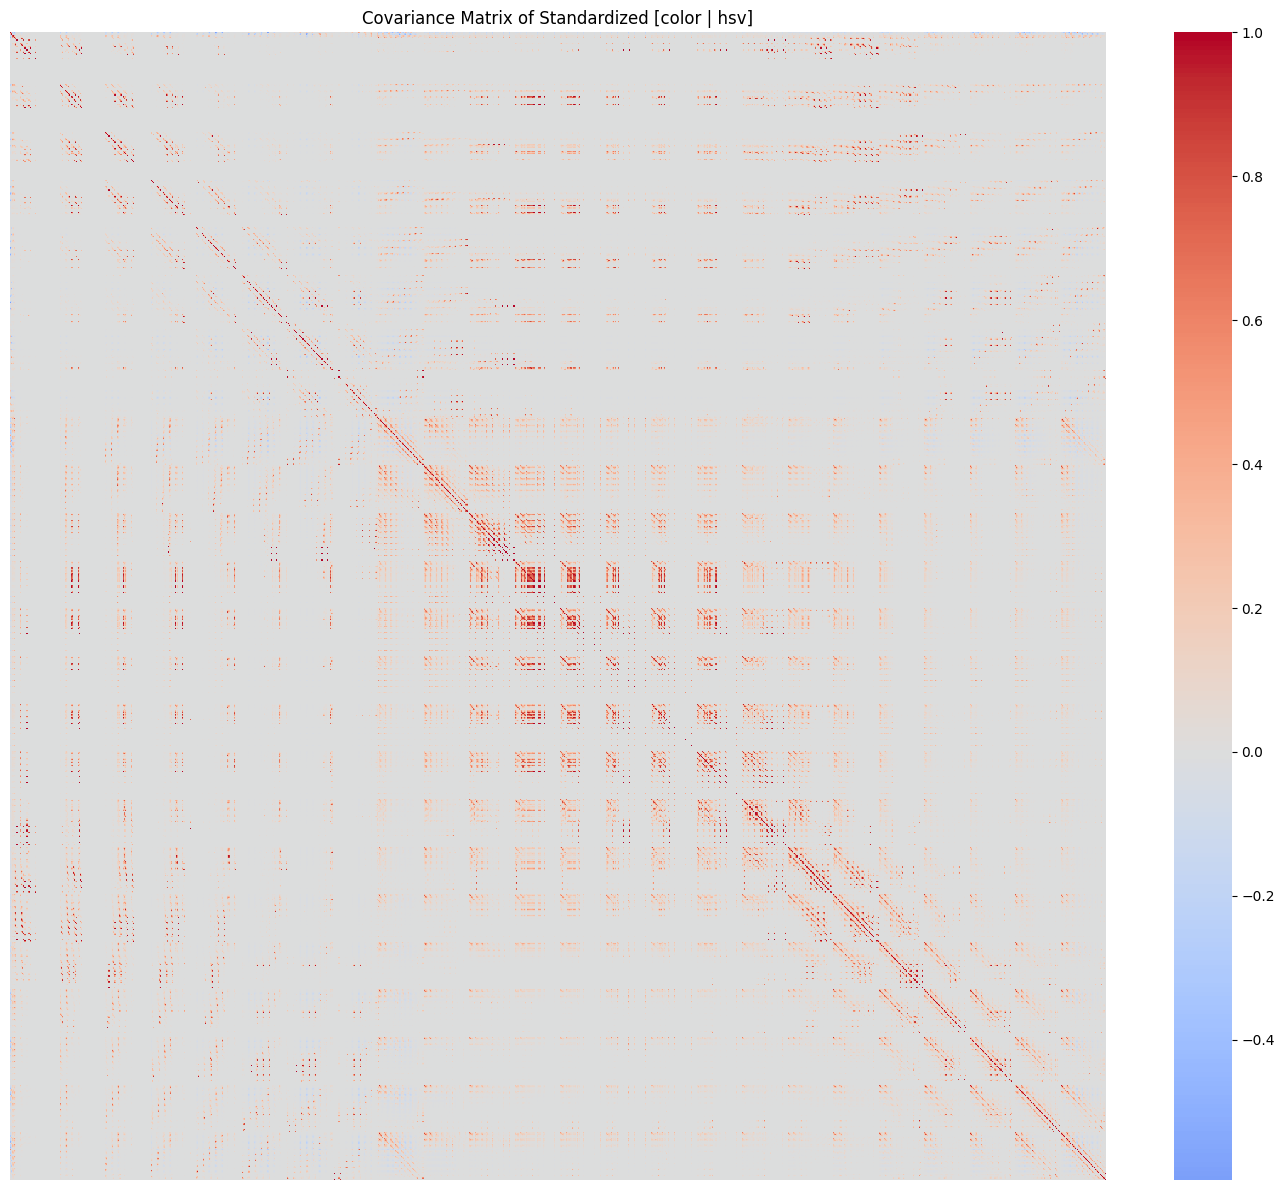

In [55]:
cov = compute_covariance_matrix(X_color, X_hsv, visualize=True, label1='color', label2='hsv')


Analysis: Domain analysis suggested correlation between color and hsv. AUC scores for each feature were similar, confirming our suspicion. The covariance matrix between the two features confirms this suspicion.

# Classification Run (selected simple features, and resnet)

In [22]:
raw_labels = np.array(labels)

In [23]:
# Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(raw_labels)
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
class_mapping

{0: np.str_('akiec'),
 1: np.str_('bcc'),
 2: np.str_('bkl'),
 3: np.str_('df'),
 4: np.str_('mel'),
 5: np.str_('nv'),
 6: np.str_('vasc')}

In [59]:
# Load X_Resnet
import numpy as np
from pathlib import Path

# Define the path to your .npz file on Google Drive
base_dir = Path('/content/drive/MyDrive/w81_fp')
file_path = base_dir / 'resnet_features_with_ids.npz'

# Load the .npz file
data = np.load(file_path, allow_pickle=True)

# Extract contents
X_resnet   = data['X_resnet']
labels     = data['labels'].tolist()
image_ids  = data['image_ids'].tolist()

# Confirm shape
print("Loaded ResNet features")
print("X_resnet shape:", X_resnet.shape)
print("Labels count:", len(labels))
print("Image IDs count:", len(image_ids))


Loaded ResNet features
X_resnet shape: (10015, 2048)
Labels count: 10015
Image IDs count: 10015


In [60]:
print(f"{ X_hsv.shape = }, { X_gabor.shape = }, { X_lbp.shape = }, { X_glcm.shape = }")

 X_hsv.shape = (10015, 1024),  X_gabor.shape = (10015, 48),  X_lbp.shape = (10015, 10),  X_glcm.shape = (10015, 6)


In [61]:
X_combined = np.hstack([X_resnet, X_hsv, X_gabor, X_lbp, X_glcm])

In [62]:
X_combined.shape

(10015, 3136)

In [69]:
whoAmI(y)

dtype     : int64
min       : 0.0000
max       : 6.0000
mean      : 4.1823
shape     : (10015,)


# Weighting (AUC-ROC Optimized)

In [24]:
def run_auc_roc_gpu_evaluation_with_class_weights(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated evaluation for a single model using balanced class weights.

    This function expects the model to handle class imbalance internally via
    the `class_weight='balanced'` parameter, instead of using oversampling.

    Args:
        model_name (str): The name of the model to evaluate from MODELS_CUML. The model
                          should be instantiated with `class_weight='balanced'`.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model.
    """
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    config = MODELS_CUML[model_name]

    # Step 1: Data splitting (remains the same)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=random_state
    )

    print(f"--- Starting Evaluation for: {model_name} (using class weights) ---")

    # Step 2: Set up hyperparameter search directly on the model
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    bayes_search = BayesSearchCV(
        estimator=config['model'],
        search_spaces=config['params'],
        n_iter=2, # have to set this in order for SVC to complete
        cv=cv,
        scoring='roc_auc_ovr',
        n_jobs=1,
        random_state=random_state,
        verbose=1
    )

    # Step 3: Run the Bayesian search
    print("Running Bayesian search...")
    bayes_search.fit(X_train, y_train)

    # Step 4: Find optimal thresholds (remains the same)
    best_model = bayes_search.best_estimator_
    y_val_pred_proba = best_model.predict_proba(X_val)

    print("Finding optimal thresholds on validation set...")
    thresholds = []
    for i in range(y_val_pred_proba.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for thresh in np.arange(0.01, 1.0, 0.01):
            y_pred_binary = (y_val_pred_proba[:, i] >= thresh).astype(int)
            y_true_binary = (y_val == i).astype(int)
            f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)
    print(f"Optimal thresholds found: {np.round(thresholds, 2)}")

    # Step 5: Evaluate on test set with custom thresholds (remains the same)
    print("Evaluating best model on the hold-out test set with custom thresholds...")
    y_test_pred_proba = best_model.predict_proba(X_test)

    final_predictions = []
    for probs in y_test_pred_proba:
        passed_threshold_indices = [i for i, prob in enumerate(probs) if prob >= thresholds[i]]
        if not passed_threshold_indices:
            final_predictions.append(np.argmax(probs))
        else:
            best_class = max(passed_threshold_indices, key=lambda idx: probs[idx])
            final_predictions.append(best_class)

    y_test_pred = np.array(final_predictions)

    # Final reporting
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro')

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_roc_auc': bayes_search.best_score_,
        'test_set_roc_auc': test_auc,
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation AUC-ROC score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    return {model_name: final_results}

In [ ]:
#xgb_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('XGBoost_GPU_Balanced', X_combined, y)

In [71]:
rf_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('RandomForest_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: RandomForest_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finding optimal thresholds on validation set...
Optimal thresholds found: [0.17 0.18 0.22 0.07 0.21 0.44 0.08]
Evaluating best model on the hold-out test set with custom thresholds...
Best cross-validation AUC-ROC score: 0.9314
Best hyperparameters: OrderedDict([('max_depth', 23), ('n_bins', 95), ('n_estimators', 470)])
Test Set AUC-ROC score: 0.9383

Test set classification report:
              precision    recall  f1-score      support
0              0.500000  0.338462  0.403670    65.000000
1              0.596774  0.359223  0.448485   103.000000
2              0.521531  0.495455  0.508159   220.000000
3              0.000000  0.000000  0.000000    23.000000
4              0.516854  0.412556  0.458853   223.000000
5              0.847176  0.950783  0.895994  1

In [72]:
##Run with color instead of HSV
X_combined = np.hstack([X_resnet, X_color, X_gabor, X_lbp, X_glcm])

In [73]:
X_combined.shape

(10015, 2630)

In [74]:
rf_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('RandomForest_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: RandomForest_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finding optimal thresholds on validation set...
Optimal thresholds found: [0.19 0.19 0.23 0.07 0.2  0.42 0.08]
Evaluating best model on the hold-out test set with custom thresholds...
Best cross-validation AUC-ROC score: 0.9285
Best hyperparameters: OrderedDict([('max_depth', 23), ('n_bins', 95), ('n_estimators', 470)])
Test Set AUC-ROC score: 0.9374

Test set classification report:
              precision    recall  f1-score      support
0              0.560976  0.353846  0.433962    65.000000
1              0.654545  0.349515  0.455696   103.000000
2              0.532020  0.490909  0.510638   220.000000
3              0.750000  0.130435  0.222222    23.000000
4              0.535714  0.403587  0.460358   223.000000
5              0.835294  0.953020  0.890282  1

# CLIP

In [25]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q ftfy regex tqdm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00


In [4]:
import clip
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np

def extract_clip_features(images_np, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract CLIP image features using ViT-B/32.

    Parameters:
        images_np: np.array of shape (N, H, W, 3), pixel values in [0, 1]
        device: 'cuda' or 'cpu'

    Returns:
        features: np.array of shape (N, 512)
    """
    model, preprocess = clip.load("ViT-B/32", device=device)
    model.eval()

    features = []

    with torch.no_grad():
        for img in tqdm(images_np, desc="Extracting CLIP Features"):
            # Convert float32 image [0,1] to uint8 [0,255] and to PIL
            img_pil = Image.fromarray((img * 255).astype(np.uint8))
            input_tensor = preprocess(img_pil).unsqueeze(0).to(device)  # (1, 3, 224, 224)
            embedding = model.encode_image(input_tensor)                # (1, 512)
            features.append(embedding.squeeze().cpu().numpy())

    return np.array(features)  # (N, 512)


In [6]:
import numpy as np
from pathlib import Path

def load_processed_data(base_dir="/content/drive/MyDrive/w81_fp", filename="processed_data.npz"):
    """
    Load preprocessed image data from a .npz file.

    Parameters:
    - base_dir: str or Path to the folder where the .npz file is stored
    - filename: name of the .npz file (default = 'processed_data.npz')

    Returns:
    - processed_images: np.array of shape (N, H, W, 3)
    - labels: list of class labels
    - image_ids: list of image IDs
    """
    base_path = Path(base_dir)
    file_path = base_path / filename

    data = np.load(file_path, allow_pickle=True)

    processed_images = data['images']
    labels = data['labels'].tolist()
    image_ids = data['image_ids'].tolist()

    print(" Loaded processed data")
    print("Images shape:", processed_images.shape)
    print("Labels count:", len(labels))
    print("Image IDs count:", len(image_ids))

    return processed_images, labels, image_ids


In [7]:
processed_images, labels, image_ids = load_processed_data()

 Loaded processed data
Images shape: (10015, 224, 224, 3)
Labels count: 10015
Image IDs count: 10015


In [8]:
print(f" {processed_images.shape = }, { len(image_ids) = }, { len(labels) = }")

 processed_images.shape = (10015, 224, 224, 3),  len(image_ids) = 10015,  len(labels) = 10015


In [11]:
raw_labels = np.array(labels)

In [12]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(raw_labels)
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
class_mapping


{0: np.str_('akiec'),
 1: np.str_('bcc'),
 2: np.str_('bkl'),
 3: np.str_('df'),
 4: np.str_('mel'),
 5: np.str_('nv'),
 6: np.str_('vasc')}

In [ ]:
X_clip = extract_clip_features(processed_images)
print("-"*150)
print(" CLIP feature extraction complete, features shape:", X_clip.shape)
print("saving CLIP features to disk")




In [14]:
X_clip.shape

(10015, 512)

In [15]:
##persist features to disk
from pathlib import Path
import numpy as np

# Define your Google Drive directory
base_dir = Path("/content/drive/MyDrive/w81_fp")
save_path = base_dir / "clip_features_with_ids.npz"
# Assuming X_clip, labels, and image_ids are already defined
np.savez_compressed(save_path,
                    X_clip=X_clip,
                    labels=np.array(labels),
                    image_ids=np.array(image_ids))

print(f"CLIP features saved to: {save_path}")


CLIP features saved to: /content/drive/MyDrive/w81_fp/clip_features_with_ids.npz


In [16]:
import numpy as np
from pathlib import Path

# Define the path to the saved file
base_dir = Path("/content/drive/MyDrive/w81_fp")
file_path = base_dir / "clip_features_with_ids.npz"

# Load the .npz file
data = np.load(file_path, allow_pickle=True)

# Extract features and metadata
X_clip2    = data["X_clip"]
labels     = data["labels"].tolist()
image_ids  = data["image_ids"].tolist()

print(" Loaded X_clip2:", X_clip2.shape)
print("Sample labels:", labels[:3])
print("Sample image_ids:", image_ids[:3])


 Loaded X_clip2: (10015, 512)
Sample labels: ['bkl', 'bkl', 'bkl']
Sample image_ids: ['ISIC_0027419', 'ISIC_0025030', 'ISIC_0026769']


In [1]:
# import torch
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: True
Device: NVIDIA A100-SXM4-40GB


In [2]:
# #  Reinstall PyTorch + torchvision for CUDA 12.1 (recommended for A100)
# !pip install -U --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [1]:
# import torch
# print("CUDA:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))


CUDA: True
Device: NVIDIA A100-SXM4-40GB


In [2]:
# x = torch.randn(1000, 1000).to("cuda")
# y = x @ x
# print("Test passed:", y.shape)


Test passed: torch.Size([1000, 1000])


In [18]:
import numpy as np
from pathlib import Path

# Define the path to the .npz file
base_dir = Path("/content/drive/MyDrive/w81_fp")
file_path = base_dir / "simple_feature_set_all.npz"

# Load the .npz file
data = np.load(file_path, allow_pickle=True)

# List available keys
print(" Keys in file:", data.files)


 Keys in file: ['X_hog', 'X_hsv', 'X_lbp', 'X_color', 'X_intensity', 'X_glcm', 'X_gabor', 'X_shape', 'X_corners', 'X_sift', 'X_wavelet', 'X_sobel', 'labels', 'image_ids']


In [20]:
# Load individual features (use keys shown from data.files output)
X_hog       = data["X_hog"]
X_hsv       = data["X_hsv"]
X_lbp       = data["X_lbp"]
X_color     = data["X_color"]
X_intensity = data["X_intensity"]
X_glcm      = data["X_glcm"]
X_gabor     = data["X_gabor"]
X_shape     = data["X_shape"]
X_corners   = data["X_corners"]
X_sift      = data["X_sift"]
X_wavelet   = data["X_wavelet"]
X_sobel     = data["X_sobel"]

# Metadata
labels     = data["labels"].tolist()
image_ids  = data["image_ids"].tolist()

print(" Loaded simple features:")
print("X_hog shape:", X_hog.shape)
print("X_hsv shape:", X_hsv.shape)
print("Total labels:", len(labels))


 Loaded simple features:
X_hog shape: (10015, 26244)
X_hsv shape: (10015, 1024)
Total labels: 10015


In [22]:
## Clip Classification


X_combined = np.hstack([X_clip, X_hsv, X_gabor, X_lbp, X_glcm])
X_combined2 = np.hstack([X_clip, X_color, X_gabor, X_lbp, X_glcm])

print(f" { X_combined.shape = }, { X_combined2.shape = } ")

  X_combined.shape = (10015, 1600),  X_combined2.shape = (10015, 1094) 


In [30]:
#clip + hsv + gabor + lbp + glcm
rf_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('RandomForest_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: RandomForest_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finding optimal thresholds on validation set...
Optimal thresholds found: [0.19 0.16 0.22 0.04 0.2  0.39 0.1 ]
Evaluating best model on the hold-out test set with custom thresholds...
Best cross-validation AUC-ROC score: 0.9238
Best hyperparameters: OrderedDict([('max_depth', 23), ('n_bins', 95), ('n_estimators', 470)])
Test Set AUC-ROC score: 0.9363

Test set classification report:
              precision    recall  f1-score      support
0              0.555556  0.538462  0.546875    65.000000
1              0.529412  0.262136  0.350649   103.000000
2              0.518750  0.377273  0.436842   220.000000
3              0.000000  0.000000  0.000000    23.000000
4              0.506667  0.340807  0.407507   223.000000
5              0.821360  0.963460  0.886754  1

In [31]:
#clip + color + gabor + lbp + glcm
rf_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('RandomForest_GPU_Balanced', X_combined2, y)


--- Starting Evaluation for: RandomForest_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finding optimal thresholds on validation set...
Optimal thresholds found: [0.15 0.15 0.23 0.05 0.26 0.52 0.06]
Evaluating best model on the hold-out test set with custom thresholds...
Best cross-validation AUC-ROC score: 0.9215
Best hyperparameters: OrderedDict([('max_depth', 23), ('n_bins', 95), ('n_estimators', 470)])
Test Set AUC-ROC score: 0.9335

Test set classification report:
              precision    recall  f1-score      support
0              0.486111  0.538462  0.510949    65.000000
1              0.520408  0.495146  0.507463   103.000000
2              0.504717  0.486364  0.495370   220.000000
3              0.333333  0.086957  0.137931    23.000000
4              0.527397  0.345291  0.417344   223.000000
5              0.855967  0.930649  0.891747  1

----Some additional feature correlation analysis between X_color and X_hsv
